# Notebook that conducts the training and saving of the models

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from os import listdir
from os.path import isfile, join
import os
import re
import numpy as np
import pandas as pd
import pickle
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, multilabel_confusion_matrix
from sklearn.datasets import make_multilabel_classification
import xgboost as xgb 
from scipy.signal import find_peaks, stft, istft
import xgboost as xgb 
from scipy.signal import butter, lfilter
# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording, Trace, Activity, WatchLocation, Path

pd.options.display.max_seq_items = 5000

# Helpers

In [3]:
SENSOR_DIFF_SAMPLE_RATE = ["mx", "my", "mz", "altitude"]
MEASURES = ["mean", "std", "energy", "max_freq"]
SENSOR_CORR = ["ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz", "altitude"]
METRICS = ["ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz", "altitude", "Steps", "StepsWindow"]
MAX_LENGTH = 919.935
SAMPLING_RATE = 200

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plot_signal(signal, title, ylabel, sampling_rate=SAMPLING_RATE, peaks=[]):
    x = np.linspace(0, len(signal) / sampling_rate, len(signal))
    t = pd.to_datetime(x, unit='s')

    fig, ax = plt.subplots()
    ax.plot(t if len(peaks) == 0 else np.linspace(0, len(signal), len(signal)) , signal)
    ax.set_title(title)
    ax.set_xlabel('Time [min:sec]' if len(peaks) == 0 else "Indexes")
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    
    # Plot peaks if given
    if len(peaks) != 0:
        plt.plot(peaks, signal[peaks], "x", color="green")
    plt.show()

def get_signal_mag(ax, ay, az):

    return (ax**2 + ay**2 + az**2)**0.5

# Get magnitude walk
def get_signal_walk(path):
    recording = Recording(path)

    # Magnitude
    magn = get_signal_mag(recording.data['ax'].values, recording.data['ay'].values,  recording.data['az'].values)
    
    
    return magn, 0

# Clean low frequencies, RFFT since signals contain only real values (+faster)
def algo_walk(acc_phase, label = 0, wind_length= 7.6, mov_avg_wind_s= 0.85, std_thr= 0.15000000000000002, std_wind= 0.65, freq_max_hz= 3.0, prom = 1.65, sampling_rate = SAMPLING_RATE, show=False):
    # Number samples
    N = len(acc_phase)
    
    # Filter too high frequency out
    acc_phase = butter_bandpass_filter(acc_phase, 1, 3, sampling_rate)
    # Eval moving average over window
    mov_avg_wind = int(mov_avg_wind_s*sampling_rate)
    numbers_series = pd.Series(acc_phase)

    windows = numbers_series.rolling(mov_avg_wind, center=True)
    moving_averages = windows.mean()

    # Set first null entries from the list to zero
    moving_averages = moving_averages.fillna(0)
    acc_filt = moving_averages.to_numpy()

    # Plot filered signal
    if show:
        plot_signal(acc_phase[40*sampling_rate:45*sampling_rate], 'Magnitude Acc Original', 'Amplitude')
        plot_signal(acc_filt[40*sampling_rate:45*sampling_rate], 'Magnitude Acc Cleaned', 'Amplitude')

    # Get peaks every windows sec
    pred = 0

    # Walking or movement detection first
    step = int(std_wind*sampling_rate)
    moving = np.empty(N)
    for i in range(step, N - step):
        std_l = lambda val: np.std(val[int(i - step):int(i + step)]) > std_thr
        moving[i + step]  = std_l(acc_phase)
            
    # Copy for first and last
    moving[0:step] = moving[step:2*step]
    moving[-step:]= moving[-2*step:-step]
    if show:
        plot_signal(moving, "Accel Signal", "Moving")
        plot_signal(acc_phase, "Accel Signal original", "Moving")
    
    
    wind_step = int(wind_length*sampling_rate)
    for i in range(0, N, wind_step):
        acc_wind_filt = acc_filt[i:(i+ wind_step)]
        acc_wind_orig = acc_phase[i:(i+ wind_step)]
        moving_wind = moving[i:(i+ wind_step)]

        # Normalize
        # Here you can modify freely the parameters of find peak
        # Minimum distance for our peaks is len_signal_per_minute/max_acc_beat (30 seconds)
        distance = 1/freq_max_hz*sampling_rate
        prominence = (np.max(acc_wind_filt) - np.min(acc_wind_filt))/prom
        peaks, _ = find_peaks(acc_wind_filt, height = np.mean(acc_wind_filt), distance=distance, prominence=prominence)
        
        # Keeps peaks only where energy is not too low
        peaks = [peak for peak in peaks if moving_wind[peak]]
        # Find peaks with double heel, remove half
        pred += len(peaks)
        

        # Plot example in range
        if i == 8*wind_step and show:
            plot_signal(acc_wind_orig, 'Acc Orig from {} to {} s'.format(i*sampling_rate, (i+ 10)*sampling_rate), 'Amplitude', peaks=peaks)
            plot_signal(acc_wind_filt, 'Acc Filt from {} to {} s'.format(i*sampling_rate, (i+ 10)*sampling_rate), 'Amplitude', peaks=peaks)
            plot_signal(moving_wind, 'Acc wrist Filt from {} to {} s'.format(i*sampling_rate, (i+ 10)*sampling_rate), 'Amplitude', peaks=peaks)

    # Print prediction of score if given heart rate ground truth
    if label != 0:   
        print("We have found {} compared to the gt of {} steps".format(pred, label))
    return pred

# Extend length of a sensor with lower sample rate to a higher by copying values
def extend_length_sensor(recording, sensor):
    sensor_ext = np.empty(recording.data["ax"].timestamps.shape)
    c = 0
    for id, time in enumerate(recording.data["ax"].timestamps):
        if recording.data[sensor].timestamps[c] < time:
            c += 1
        sensor_ext[id] = recording.data[sensor].values[c]
    return sensor_ext

def get_data_sample(path, wind_length_s, wind_overlap_per, sensors_corr = SENSOR_CORR, sensors_no_corr = [], labels=True, extend_ffill=True):
    # checking if it is a file
    assert os.path.isfile(path), "path not valid"

    # Read file
    recording = Recording(path)

    # Define variables
    sensors = sensors_corr + sensors_no_corr 
    corr = [x + "_" + y +"_" + "corr" for i, x in enumerate(sensors_corr) for y in sensors_corr[(i+1):]]
    features = [sens + "_" + meas for sens in sensors for meas in MEASURES] 
    columns = (["Sample"] + ["Steps", "Frequency", "Length", "Timestamps", "StepsWindow"] + features + corr)

    # Get frequency of sampling
    frequency = recording.data[sensors[0]].samplerate
    wind_nr_sample = int(frequency*wind_length_s)
    wind_step = int(wind_nr_sample*wind_overlap_per)
    # Get all the sensor data we want in windows
    data_rec = pd.DataFrame(columns=columns)

    # Add all sensors measures
    for sensor in sensors:
        # Extend sensors with diff sample rate
        if sensor in SENSOR_DIFF_SAMPLE_RATE:
            recording.data[sensor].values = extend_length_sensor(recording, sensor)

        # Read data as pd
        data_val = pd.DataFrame(recording.data[sensor].values)
        # Fill last values up to divisible size
        nr_miss = wind_step - len(data_val)%wind_step

        # Extend with given idea to divisible length
        if extend_ffill:
            row_pad = data_val.iloc[[-1]*nr_miss]
        else:
            row_pad = pd.DataFrame(0, index=np.arange(nr_miss), columns=data_val.columns) 
        
        data_val = pd.concat([data_val, row_pad], ignore_index=True)
        
        # Evaluate mean and std
        data_rec[sensor + "_mean"] =  data_val.rolling(window = wind_nr_sample,
        min_periods = wind_nr_sample, step = wind_step, center=True).mean()[1:]
        data_rec[sensor + "_std"] = data_val.rolling(window = wind_nr_sample,
        min_periods = wind_nr_sample, step=wind_step, center=True).std()[1:]
        # Evaluate stfft and skip first and last index since window is placed centered on first and last value
        f, t, Zxx = stft(data_val.to_numpy().squeeze(axis=1), fs=frequency, nperseg = wind_nr_sample, noverlap= wind_nr_sample - wind_step)
        Zxx = np.transpose(Zxx)[1:-1]
        energy = np.sum(np.abs(Zxx)**2, axis = 1)/wind_length_s
        data_rec[sensor + "_energy"]  = energy

        get_freq = lambda x: f[x]
        data_rec[sensor + "_max_freq"] = get_freq(np.argmax(Zxx, axis = 1))
    
    # Add nr_steps per window
    sign_mag = get_signal_mag(recording.data["ax"].values, recording.data["ay"].values, recording.data["az"].values)
    steps_per_window = np.empty(len(data_rec))
    for id, i in enumerate(range(wind_step, len(sign_mag) - wind_step, wind_step)):
        steps_per_window[id] = algo_walk(sign_mag[i-wind_step:i+wind_step])

    data_rec["StepsWindow"] = steps_per_window

    # Put constant values
    data_rec["Steps"] = algo_walk(sign_mag)

    data_rec["Sample"] = path 
    data_rec["Frequency"] = recording.data[sensors[0]].samplerate
    data_rec["Length"] = recording.data[sensors[0]].total_time
    data_rec["Timestamps"] = np.arange(0, len(data_rec), 1)/200
    
    if labels:
        # Add activity
        for activity in Activity:
            data_rec[activity.name] = 1*(activity.value in recording.labels["activities"])

        # Add path loc
        data_rec["path_idx"] = recording.labels["path_idx"]
        
        # Add watch loc
        data_rec["watch_loc"] = recording.labels["watch_loc"]


    # Reset indexes
    data_rec.reset_index(drop=True, inplace=True)

    # Add correlations between requested sensors
    for i, sens_x in enumerate(sensors_corr):
        sens_x_val = recording.data[sens_x].values
        for sens_y in sensors_corr[(i+1):]:
            pd_corr = pd.DataFrame(np.transpose(np.vstack((sens_x_val, recording.data[sens_y].values))))
            nr_miss = wind_step - len(pd_corr)%wind_step
            # Get perfect length divisiblity by wind_length
            if extend_ffill:
                row_pad = pd_corr.iloc[[-1]*nr_miss]
            else:
                row_pad = pd.DataFrame(0, index=np.arange(nr_miss), columns=pd_corr.columns)
            pd_corr = pd.concat([pd_corr, row_pad], ignore_index=True)
            
            # Need optimize but rolling no support for corr yet
            for id, i in enumerate(range(0, len(pd_corr) - wind_step, wind_step)):
                corr_matrix = pd_corr[i:i + wind_nr_sample].corr()  
                data_rec.at[id, sens_x + "_" + sens_y +"_" + "corr" ] = corr_matrix.iloc[0, 1]
    
    # Fill Na values of last row per sample
    data_rec = data_rec.fillna(method='ffill')
    data_rec = data_rec.fillna(method='bfill')
    
    return data_rec
                
                

# Get data accel with corresponding label from all the path as df
def get_data(path, wind_length_s = 200, wind_overlap_per = 1, sensors_corr = SENSOR_CORR, sensors_no_corr = [], labels=True, extend_ffill = True):
    
    data = pd.DataFrame()
    for idx, filename in enumerate(os.listdir(path)):
        f = os.path.join(path, filename)
        
        # Get data per sample
        data_rec = get_data_sample(f, wind_length_s, wind_overlap_per, sensors_corr, sensors_no_corr, labels, extend_ffill)
        
        # Init data if first file
        if idx == 0:
            data = data_rec
            continue
        # Concatenate two dataframes
        data = pd.concat([data, data_rec], ignore_index=True)
        if idx % 10 == 1:
            print("Processed {} examples".format(idx))
    
    return data  

# Keep only features. Attention, features_corr need to give feats in correct order ex. ax, az, gx, gy, mz
def drop_features(df, features, features_corr, measures):
    corr_feats = [x for x in df.columns for y in features_corr if y in x]
    features_measures = [x for x in df.columns for y in features if y in x]
    measures_drop = [x for x in df.columns for y in measures if y in x]
    return df.drop(features_measures + corr_feats + measures_drop, axis = 1)

# Recall corr is standardized
def drop_low_corr(df, corr_mean_treshold  = 0.01, corr_std_treshold = 0.25):
    corr_names = [x + "_" + y +"_" + "corr" for i, x in enumerate(SENSOR_CORR) for y in SENSOR_CORR[(i+1):]]
    low_corr_feats = []
    for corr_col in corr_names:
        if df[corr_col].abs().mean() < corr_mean_treshold or df[corr_col].std() < corr_std_treshold :
            df = df.drop([corr_col], axis=1)
            low_corr_feats.append(corr_col)

    return df, low_corr_feats

# Extend the df to have at least max_window elements per sample, where the padding is with 0
def extend_df_windows(df, data_every = 30, wind_length_s = 60, wind_overlap_per = 0.5):
    wind_step = wind_length_s*wind_overlap_per
    max_window = int((MAX_LENGTH)//wind_step)

    # Create max_window consecutive rows
    df['g'] = df.groupby('Sample').cumcount()
    mux = pd.MultiIndex.from_product([df['Sample'].unique(), range(max_window)], names=('Sample','g'))

    df = (df.set_index(['Sample','g'])
        .reindex(mux, fill_value=0)
        .reset_index(level=1, drop=True)
        .reset_index())
    

    # Reduce number of rows by
    rol = max_window//data_every

    df_label = df[["Sample"]].iloc[rol - 1::rol, :]
    df = df.drop(["Sample"], axis=1).rolling(rol).mean() 

    df = df.iloc[rol - 1::rol, :]
    
    df = pd.concat([df_label, df], axis = 1).reset_index(drop=True)
                
    # Group every max_window rows
    s = df.groupby(['Sample']).cumcount()

    df1 = df.set_index(['Sample', s]).unstack().sort_index(level=1, axis=1)
    df1.columns = [f'{x}{y}' for x, y in df1.columns]
    df1 = df1.reset_index()

    return df1

# Get features per sample across windows
def features_per_sample(df):
    mean = df.groupby('Sample').mean()
    mean = mean.add_prefix("mean_")
    std = df.groupby('Sample').std()
    std = std.add_prefix("std_")

    quantile25 = df.groupby('Sample').quantile(q=0.25)
    quantile25 = quantile25.add_prefix("q25_")

    quantile75 = df.groupby('Sample').quantile(q=0.75)
    quantile75 = quantile75.add_prefix("q75_")

    df_final =  pd.concat([mean, std, quantile25, quantile75], axis = 1)
    return df_final 

In [ ]:
path = "data/train/"
# Get df for training
df = get_data(path, wind_length_s = 60, wind_overlap_per = 0.5)
df.to_csv("group33_features.csv", index=False)

In [5]:
measures_drop = ["energy"]
features_train_remove = ["Frequency", "path_idx", "watch_loc", "Length", "Steps", "STANDING", "Timestamps", "WALKING",	"RUNNING",	"CYCLING"]

features_watch_remove = ["altitude", "Steps", "StepsWindow", "mx", "my", "mz"]
features_activ_remove = ["altitude", "mx", "my", "mz"]

features_path_remove = ["ax", "ay", "az", "gx", "gy", "gz"]
measures_drop_path = ["energy", "max_freq"]

# Train Watch

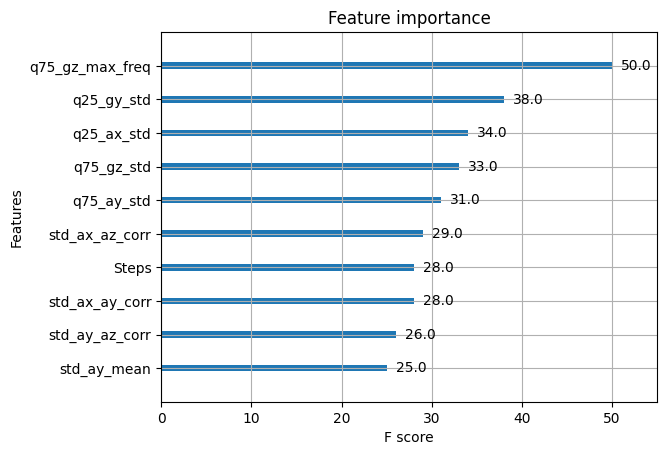

In [13]:
# Get labels
labels = df.groupby('Sample').max()[["watch_loc"]]
steps = df.groupby('Sample').max()[["Steps"]]

df_filt = df.drop(features_train_remove, axis=1)
# Remove not highly correlated features
df_filt, low_corr_features = drop_low_corr(df_filt)

# Remove features which seems not useful for watch loc

df_filt = drop_features(df_filt, features_watch_remove, features_watch_remove, measures_drop)
df_features_samples = features_per_sample(df_filt)
#df_features_samples = extend_df_windows(df_filt).set_index("Sample")

df_final =  pd.concat([df_features_samples, labels[['watch_loc']], steps[["Steps"]]], axis=1)

train = df_final.reset_index(drop=True)

X_train = train.drop(['watch_loc'], axis =1)
y_train = train[['watch_loc']]

clf_watch = xgb.XGBClassifier(n_estimators = 1000)
clf_watch.fit(X_train, y_train)

xgb.plot_importance(clf_watch, max_num_features=10)

file_name = "clf_watch.pkl"

# save
pickle.dump(clf_watch, open(file_name, "wb"))

# Train Path

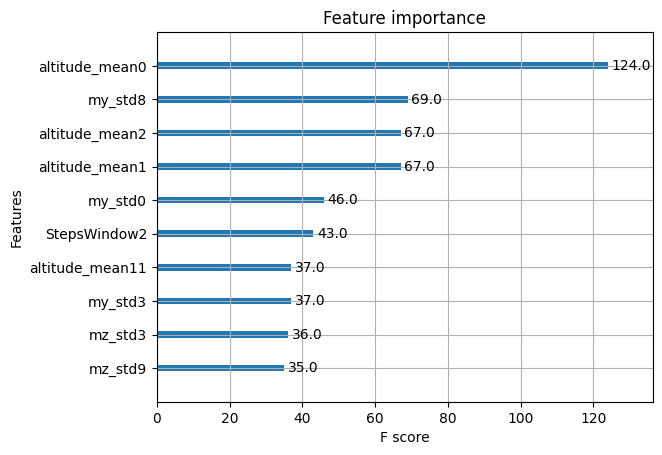

In [10]:
# Get labels
labels = df.groupby('Sample').max()[["path_idx"]]
steps = df.groupby('Sample').max()[["Steps"]]

df_filt = df.drop(features_train_remove, axis=1)
# Remove not highly correlated features
df_filt, low_cor_features = drop_low_corr(df_filt)

# Remove features which seems not useful for path loc
df_filt = drop_features(df_filt, features_path_remove, features_path_remove, measures_drop_path)
# df_features_samples = features_per_sample(df_filt)
df_features_samples = extend_df_windows(df_filt).set_index("Sample")

df_final =  pd.concat([df_features_samples, labels[['path_idx']], steps[["Steps"]]], axis=1)
train = df_final.reset_index(drop=True)

X_train = train.drop(['path_idx'], axis =1)
y_train = train[['path_idx']]

clf_path = xgb.XGBClassifier(n_estimators=1000)
clf_path.fit(X_train, y_train)

xgb.plot_importance(clf_path, max_num_features=10)

file_name = "clf_path.pkl"

# save
pickle.dump(clf_path, open(file_name, "wb"))

# Activity Recognition

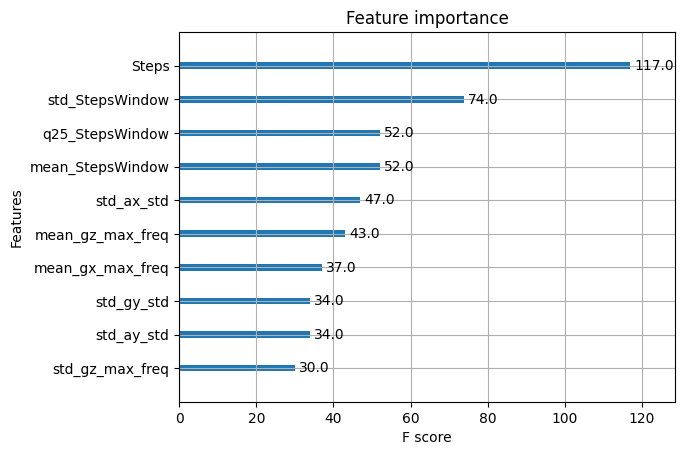

In [12]:
# Get labels
labels = df.groupby('Sample').sum()[["STANDING", "WALKING",	"RUNNING",	"CYCLING"]]
labels[labels >= 1] = 1
steps = df.groupby('Sample').max()[["Steps"]]


df_filt = df.drop(features_train_remove, axis=1)
# Remove not highly correlated features
df_filt, low_cor_features = drop_low_corr(df_filt)

# Remove features which seems not useful for activ loc

df_filt = drop_features(df_filt, features_activ_remove, features_activ_remove, measures_drop)

df_features_samples = features_per_sample(df_filt)
#df_features_samples = extend_df_windows(df_filt).set_index("Sample")

df_final =  pd.concat([df_features_samples, labels[['STANDING', 'WALKING', 'RUNNING', 'CYCLING']], steps[["Steps"]]], axis=1)
train = df_final.reset_index(drop=True)

X_train = train.drop(['STANDING', 'WALKING', 'RUNNING', 'CYCLING'], axis =1)
y_train = train[['STANDING', 'WALKING', 'RUNNING', 'CYCLING']]

clf_activ = xgb.XGBClassifier(n_estimators=1000)
clf_activ.fit(X_train, y_train)

xgb.plot_importance(clf_activ, max_num_features=10)

file_name = "clf_activ.pkl"

# save
pickle.dump(clf_activ, open(file_name, "wb"))

# Preprocess Test data

In [ ]:
# Get the path for all test traces
dir_traces = "./data/test/"#'/kaggle/input/24-exercise2/data/test'

# Preprocess features test
data_test = get_data(dir_traces, wind_length_s = 60, wind_overlap_per = 0.5, labels=False)
data_test.to_csv("group33_features_test.csv", index=False)